In [5]:
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
import time

In [6]:
def basic_square_map(N_nodes):
    dimensions =  int(np.ceil(np.sqrt(N_nodes)))
    mat = np.arange(1,N_nodes+1,1)
    for i in range(dimensions**2 - N_nodes):
        mat = np.append(mat,-1)
    mat = np.reshape(mat,(-1,dimensions))
    return mat

In [7]:
def straight_line_distances(node_map,N_nodes,scaling =1):
    distances = np.zeros((N_nodes,N_nodes))
    for i in range(1, N_nodes+1):
        node_index = np.argwhere(node_map == i)[0]
        for j in range(1, N_nodes+1):
            if i !=j:
                other_index = np.argwhere(node_map == j)[0]
                x_dist = node_index[0] - other_index[0]
                y_dist = node_index[1] - other_index[1]
                str_line = np.sqrt((x_dist)**2 + (y_dist)**2) #pythagorus
                distances[i-1,j-1] = str_line * scaling
                distances[j-1,i-1] = str_line * scaling
    return distances

In [8]:
def basic_kernel(rate,distance):
    if distance != 0:
        return rate/((distance**4)*100)
    else:
        raise ValueError("Dividing by Zero! The Kernel is working on the same node. Stop it!")

In [9]:
def meta_SIR(X0,beta,gamma,N_nodes,distances,kernel,tmax,tstep,rng,cull_strength =0):
    """
    :param X0: The initial State of the metapopulations. Needs to match the number of nodes.
    :param beta: The rate of infection
    :param gamma: The rate of recovery
    :param nodes: The number of nodes in the system
    :param kernel: The perturbation kernel
    :param tmax:
    :param tstep:
    :param rng:
    :param cull_strength:
    :return:
    """
    #set initial conditions
    t =0.0
    times = np.array(t)
    X = np.array(X0)
    timed_sol = np.array([X0])
    sol = np.array([X0])
    times = np.array(t)
    state = np.array([X0])
    nodes = {}
    node_list = np.arange(1,N_nodes+1,1)
    #set initial infection forces
    for j in node_list:
        nodes[f"node{j}"] = {}
        nodes[f"node{j}"]["domestic_inf"] = beta*X[j-1][0]*X[j-1][1]/sum(X[j-1])
        nodes[f"node{j}"]["recovery"] = gamma*X[j-1][1]
        nodes[f"node{j}"]["foreign_inf"] = 0
    for j in node_list:
        other_nodes = np.delete(node_list,[j-1])
        for i in other_nodes:
                nodes[f"node{j}"]["foreign_inf"] += kernel(beta*X[j-1][0]*X[i-1][1]/sum(X[j-1]),distances[j-1,i-1])
        nodes[f"node{j}"]["total"] =   sum(nodes[f"node{j}"].values())

    while t < tmax:
        #work out total event force
        R_tot = 0
        for j in node_list:
            R_tot += nodes[f"node{j}"]["total"]

        #if the system is still dynamic
        if R_tot > 0:
            u = rng.exponential(1/R_tot)
            t = t+ u

            z = rng.random()

            chances = np.cumsum(np.array([nodes[f"node{j}"]["total"]/R_tot for j in node_list]))

            probs = chances - z

            event_node = N_nodes - len(np.array([node for node in probs if node >= 0])) + 1

            if event_node == 1:
                zz = z
            else:
                zz = z-chances[event_node-2]

            inf_force = (nodes[f"node{event_node}"]["domestic_inf"] + nodes[f"node{event_node}"]["foreign_inf"])
            recovery_force = nodes[f"node{event_node}"]["recovery"]
            if zz <= ( inf_force/ R_tot):
                X[event_node-1] = X[event_node-1] + [-1,1,0]
            elif inf_force/R_tot < zz <= (inf_force+recovery_force)/R_tot:
                X[event_node-1] = X[event_node-1] + [0,-1,1]
            else:
                #print(f"Error @ zz={zz}, @ inf = {inf_force/R_tot}, @ rec = {recovery_force/R_tot}")
                #print(f"Event_Node = {event_node}, chance array = {chances}, z = {z}")
                #print(R_tot)
                #print(nodes)
                raise ValueError("ZZ not calculating properly")

            nodes[f"node{event_node}"]["domestic_inf"] = beta*X[event_node-1][0]*X[event_node-1][1]/sum(X[event_node-1])
            nodes[f"node{event_node}"]["recovery"] = gamma*X[event_node-1][1]

            for j in node_list:
                other_nodes = np.delete(node_list,[j-1])
                nodes[f"node{j}"]["foreign_inf"] = 0
                for i in other_nodes:
                    nodes[f"node{j}"]["foreign_inf"] += kernel(beta*X[j-1][0]*X[i-1][1]/sum(X[j-1]),distances[j-1,i-1])
                nodes[f"node{j}"]["total"] = 0
                nodes[f"node{j}"]["total"] = sum(nodes[f"node{j}"].values())


            timed_sol = np.append(timed_sol,[X],axis = 0)
            times = np.append(times,t)

        else:
            return timed_sol,times

    return timed_sol,times

In [10]:
test_map = basic_square_map(10)
#print(test_map)
#print(np.argwhere(test_map == 5)[0])
test_distances = straight_line_distances(test_map,10)
print(test_distances)

[[0.         1.         2.         3.         1.         1.41421356
  2.23606798 3.16227766 2.         2.23606798]
 [1.         0.         1.         2.         1.41421356 1.
  1.41421356 2.23606798 2.23606798 2.        ]
 [2.         1.         0.         1.         2.23606798 1.41421356
  1.         1.41421356 2.82842712 2.23606798]
 [3.         2.         1.         0.         3.16227766 2.23606798
  1.41421356 1.         3.60555128 2.82842712]
 [1.         1.41421356 2.23606798 3.16227766 0.         1.
  2.         3.         1.         1.41421356]
 [1.41421356 1.         1.41421356 2.23606798 1.         0.
  1.         2.         1.41421356 1.        ]
 [2.23606798 1.41421356 1.         1.41421356 2.         1.
  0.         1.         2.23606798 1.41421356]
 [3.16227766 2.23606798 1.41421356 1.         3.         2.
  1.         0.         3.16227766 2.23606798]
 [2.         2.23606798 2.82842712 3.60555128 1.         1.41421356
  2.23606798 3.16227766 0.         1.        ]
 [2.2

In [11]:
beta = 3
gamma = 1
N = 4
X0 = [[999,1,0]]*N
tmax = 20
tstep = 0.01
rng = np.random.default_rng(1912)

In [12]:
start_time = time.time()
test_meta, test_times = meta_SIR(X0,beta,gamma,N,test_distances,basic_kernel,tmax,tstep,rng)
end_time = time.time()
print(f"Run took {end_time-start_time} seconds!")

Run took 1.361985445022583 seconds!


In [13]:
print(test_meta)

[[[999   1   0]
  [999   1   0]
  [999   1   0]
  [999   1   0]]

 [[999   0   1]
  [999   1   0]
  [999   1   0]
  [999   1   0]]

 [[999   0   1]
  [999   1   0]
  [998   2   0]
  [999   1   0]]

 ...

 [[ 80   0 920]
  [ 62   2 936]
  [ 64   0 936]
  [ 55   0 945]]

 [[ 80   0 920]
  [ 62   1 937]
  [ 64   0 936]
  [ 55   0 945]]

 [[ 80   0 920]
  [ 62   0 938]
  [ 64   0 936]
  [ 55   0 945]]]


In [14]:
node1 = test_meta[:,0]
node2 = test_meta[:,1]
node3 = test_meta[:,2]
node4 = test_meta[:,3]
final = sum([node1,node2,node3,node4])

In [15]:
print(test_times)

[ 0.          0.14807005  0.23116767 ... 18.22119938 18.55816351
 18.77695477]


C:\Users\ollie\AppData\Local\Temp\ipykernel_13988\3563609193.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


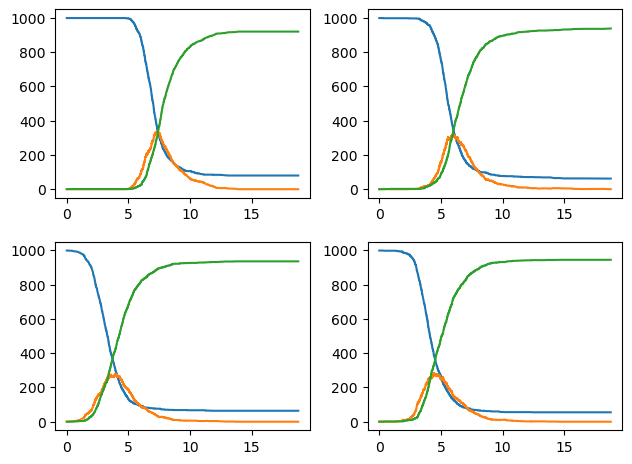

In [16]:
fig, ax0 = plt.subplots(nrows=2,ncols=2)
plt.tight_layout()
ax0 = ax0.flatten()
ax0[0].plot(test_times,node1)
ax0[1].plot(test_times,node2)
ax0[2].plot(test_times,node3)
ax0[3].plot(test_times,node4)
fig.show()

C:\Users\ollie\AppData\Local\Temp\ipykernel_13988\401191492.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


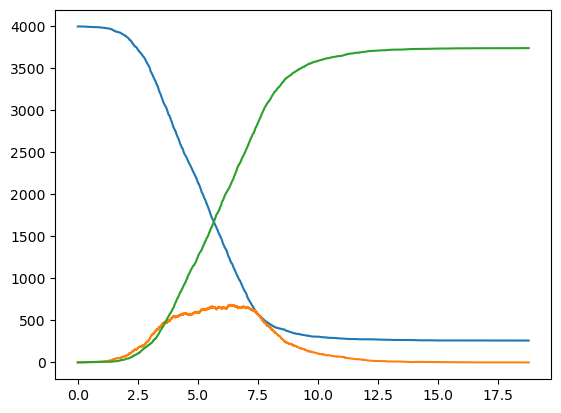

In [17]:
fig,ax0 = plt.subplots()
ax0.plot(test_times,final)
fig.show()

In [18]:
beta = 3
gamma = 1
N = 1
X0 = [[3996, 4, 0]]
tmax = 20
tstep = 0.01
rng = np.random.default_rng(1912)
start_time = time.time()
test_meta, test_times = meta_SIR(X0, beta, gamma, N, test_distances, basic_kernel, tmax, tstep, rng)
end_time = time.time()
print(f"Run took {end_time - start_time} seconds!")


Run took 0.3773322105407715 seconds!


C:\Users\ollie\AppData\Local\Temp\ipykernel_13988\2578504244.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


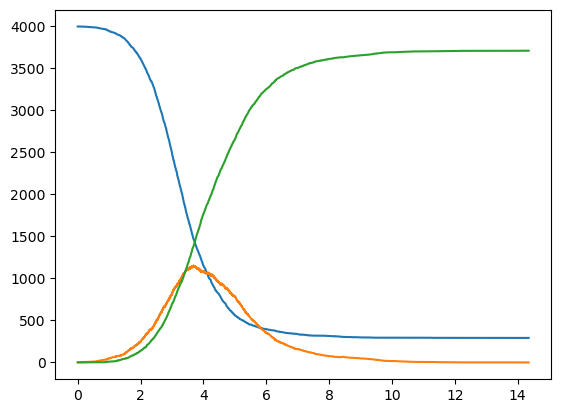

In [19]:
fig,ax0 = plt.subplots()
ax0.plot(test_times,test_meta[:,0])
fig.show()